In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import figure
import math

In [2]:
def get_surface(day):
    #Returns the surface first column is moneyness, then time to expiry, then impvol
    dummydf = day.copy()
    surface = pd.DataFrame(columns=['moneyness','time_to_expiry_yrs','impliedvol','quotedate'])
    while len(dummydf.index) > 0:
        one_exp = dummydf[dummydf['expiration'] == dummydf['expiration'][0]]
        dummydf = dummydf[dummydf['expiration'] != dummydf['expiration'][0]].reset_index()
        dummydf = dummydf[['moneyness','time_to_expiry_yrs','impliedvol','expiration','quotedate']]
        smile_slice = one_exp[['moneyness','time_to_expiry_yrs','impliedvol','quotedate']]
        surface = pd.concat([surface, smile_slice], ignore_index = True)
    return surface.to_numpy()

In [3]:
#Get surfaces for all days, input full chain here
def get_all_surfaces(options):
    dummydf = options.copy()
    surfaces = []
    while len(dummydf.index) > 0:
        day = dummydf[dummydf['quotedate'] == dummydf['quotedate'][0]]
        dummydf = dummydf[dummydf['quotedate'] != dummydf['quotedate'][0]].reset_index()
        dummydf = dummydf[['moneyness','time_to_expiry_yrs','impliedvol','expiration','quotedate']]
        surfaces.append(get_surface(day))
    return surfaces

In [4]:
def smooth_surface(points, h1,h2):
    
    def apply_estimator(moneyness, exp, points, h1, h2):
        up_sum = 0
        down_sum = 0
        for p in points:
            gk = gaussian_kernel(moneyness - p[0],exp-p[1],h1,h2)
            up_sum += gk*p[2]
            down_sum += gk
        return up_sum/down_sum
            
    def gaussian_kernel(x,y, h1, h2):
        return (1/2*math.pi)*math.exp((-x**2)/(2*h1))*math.exp((-y**2)/(2*h2))
    
    moneyness = np.linspace(0.6,1.4,50)
    expiry = np.linspace(0,2,50)
    date = points[0][3]
    surface = []
    
    for i in range(len(moneyness)):
        for j in range(len(expiry)):
            smoothed_point = apply_estimator(moneyness[i],expiry[j],points, h1, h2)
            surface.append([moneyness[i],expiry[j],smoothed_point])
    return [np.array(surface),date]
    #def convolution(m,t,h1,h2):
        
    

In [29]:
def smooth_all(all_surfaces):
    smoothed = []
    count = 0
    for surface in all_surfaces:
        if count%1 == 0:
            print(count/len(all_surfaces))
        count += 1
        smoothed.append(smooth_surface(surface,0.01,0.05))
    return smoothed

In [6]:
total_chain_W = pd.read_csv('total_chain_W.csv')
total_chain = pd.read_csv('total_chain_spx.csv')

In [7]:
all_surfaces_W = get_all_surfaces(total_chain_W)

In [8]:
all_surfaces = get_all_surfaces(total_chain)

In [30]:
all_smoothed = smooth_all(all_surfaces)

0.0
0.0028169014084507044
0.005633802816901409
0.008450704225352112
0.011267605633802818
0.014084507042253521
0.016901408450704224
0.01971830985915493
0.022535211267605635
0.02535211267605634
0.028169014084507043
0.030985915492957747
0.03380281690140845
0.036619718309859155
0.03943661971830986
0.04225352112676056
0.04507042253521127
0.04788732394366197
0.05070422535211268
0.05352112676056338
0.056338028169014086
0.059154929577464786
0.061971830985915494
0.0647887323943662
0.0676056338028169
0.07042253521126761
0.07323943661971831
0.07605633802816901
0.07887323943661972
0.08169014084507042
0.08450704225352113
0.08732394366197183
0.09014084507042254
0.09295774647887324
0.09577464788732394
0.09859154929577464
0.10140845070422536
0.10422535211267606
0.10704225352112676
0.10985915492957747
0.11267605633802817
0.11549295774647887
0.11830985915492957
0.12112676056338029
0.12394366197183099
0.1267605633802817
0.1295774647887324
0.1323943661971831
0.1352112676056338
0.13802816901408452
0.140845

In [35]:
np.save('all_smoothed', all_smoothed, allow_pickle=True, fix_imports=True)

In [36]:
as_fromfile = np.load('all_smoothed.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [24]:
sample_surface = all_surfaces[0]

In [42]:
ex_smooth = all_smoothed[1][0]
date = all_smoothed[1][1]

In [26]:
smoothed = ex_smooth[0]

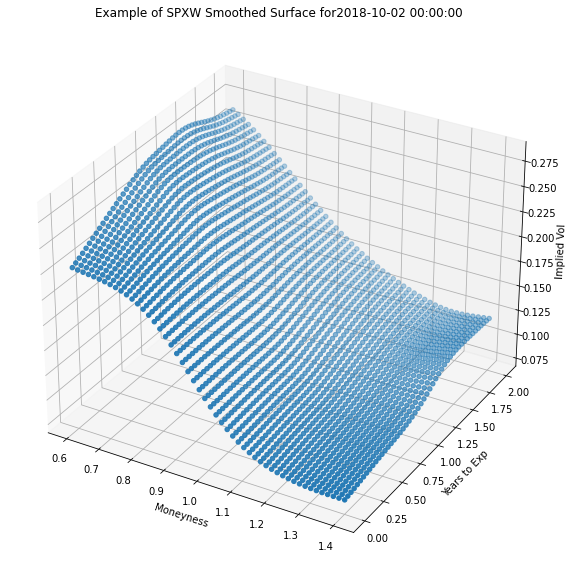

In [43]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(ex_smooth[:,0], ex_smooth[:,1], ex_smooth[:,2], marker='o')

ax.set_xlabel('Moneyness')
ax.set_ylabel('Years to Exp')
ax.set_zlabel('Implied Vol')
ax.set_title('Example of SPXW Smoothed Surface for'  + str(date))

plt.show()

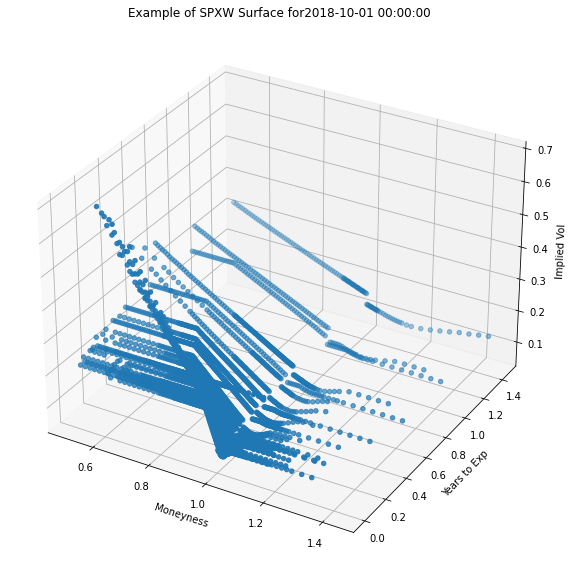

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(sample_surface[:,0], sample_surface[:,1], sample_surface[:,2], marker='o')

ax.set_xlabel('Moneyness')
ax.set_ylabel('Years to Exp')
ax.set_zlabel('Implied Vol')
ax.set_title('Example of SPXW Surface for'  + str(sample_surface[0][3]))

plt.show()